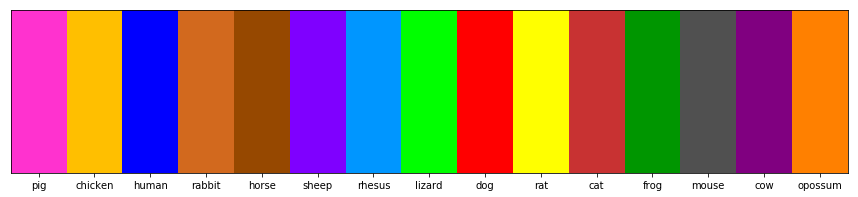

In [1]:
%matplotlib inline

import os as os
import csv as csv
import json as js
import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
from matplotlib.colors import LinearSegmentedColormap
import collections as col
import numpy as np

# What is this?
# Utility notebook to handle color conversion (rgb, hex)
# for the project - save for future use!

workdir = '/home/pebert/work/code/mpggit'

species_table = os.path.join(workdir, 'refdata', 'annotation', 'species.tsv')
assembly_table = os.path.join(workdir, 'refdata', 'annotation', 'assemblies.tsv')


def merge_annotation_tables(species, assemblies):
    """
    """
    lut_assm = dict()
    with open(assemblies, 'r', newline='') as tab:
        rows = csv.DictReader(tab, delimiter='\t')
        for row in rows:
            assert row['common_name'] not in lut_assm, 'Duplicate species: {}'.format(row)
            lut_assm[row['common_name']] = row['assembly']
    merged = []
    with open(species, 'r', newline='') as tab:
        rows = csv.DictReader(tab, delimiter='\t')
        for row in rows:
            rec = dict()
            rec['species'] = row['common_name']
            rec['assembly'] = lut_assm[rec['species']]
            rec['code'] = row['kegg_org_code']
            rec['hex'] = row['color_hex'].upper()
            merged.append(rec)
    assert len(merged) > 0, 'No records merged from annotation tables'
    return merged


def convert_species_colors(content):
    out_folder = os.path.join(workdir, 'crossspecies', 'graphics', 'colors')
    converter = mpl.colors.ColorConverter()
    species = col.defaultdict(dict)
    assembly = col.defaultdict(dict)
    code = col.defaultdict(dict)
    mapping = col.defaultdict(dict)
    for entry in content:
        rgb = converter.to_rgb('#' + entry['hex'])
        species[entry['species']]['hex'] = '#' + entry['hex']
        species[entry['species']]['rgb'] = list(rgb)
        assembly[entry['assembly']]['hex'] = '#' + entry['hex']
        assembly[entry['assembly']]['rgb'] = list(rgb)
        code[entry['code']]['hex'] = '#' + entry['hex']
        code[entry['code']]['rgb'] = list(rgb)
        mapping[entry['species']]['assembly'] = entry['assembly']
        mapping[entry['species']]['code'] = entry['code']
        mapping[entry['assembly']]['species'] = entry['species']
        mapping[entry['assembly']]['code'] = entry['code']
        mapping[entry['code']]['assembly'] = entry['assembly']
        mapping[entry['code']]['species'] = entry['species']
    joined = {'species': species, 'assembly': assembly,
              'code': code, 'mapping': mapping}
    out = os.path.join(out_folder, 'cs_colors.json')
    if os.path.isfile(out):
        with open(out, 'r') as dump:
            check = js.load(dump)
        if check != joined:
            with open(out, 'w') as dump:
                js.dump(joined, dump, indent=1, sort_keys=True)
    else:
        with open(out, 'w') as dump:
            js.dump(joined, dump, indent=1, sort_keys=True)
    return joined


def plot_colors(colors):
    
    fig, ax = plt.subplots(1, figsize=(15,3))
    label_pos = []
    labels = []
    for idx, (label, codes) in enumerate(colors.items(), start=0):
        ax.add_patch(mpatches.Rectangle((idx, 0), 1, 1, color=codes['rgb']))
        labels.append(label)
        label_pos.append(idx + 0.5)
    ax.set_xlim(0, len(colors.keys()))
    ax.set_ylim(0, 1)
    plt.xticks(label_pos, labels, rotation='0')
    plt.yticks([],[])
    plt.show()
    return


def plot_color_palette(cnames, palname, n):
    """
    """
    new_cmap = LinearSegmentedColormap.from_list(palname, cnames, N=n)
    gradient = np.linspace(0, 1, n)
    gradient = np.vstack((gradient, gradient))
    fig, ax = plt.subplots(nrows=1)
    ax.imshow(gradient, aspect='auto', cmap=new_cmap, interpolation='nearest')
    ax.set_axis_off()
    return
    

#plot_color_palette(color_list, 'blackred', 256)

records = merge_annotation_tables(species_table, assembly_table)

res = convert_species_colors(records)
plot_colors(res['species'])